# Beggining

In [9]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:

# downloading the data
#!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip
!cp /content/gdrive/MyDrive/computer_vision/starting-kit_ub-master-2023-2024/app_data_reduced.zip .

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data_reduced.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data_reduced.zip

Data decompressed successfully


In [11]:
import numpy as np

# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


## Data Augmentation

In [12]:
# Functions to transform the image

def flip(x):
    return cv2.flip(x, 1)

def gaussian_blur(x):
    return cv2.GaussianBlur(x,(5,5),3.0)

def sharpen(x):
    r = 0.3
    x_blur = cv2.GaussianBlur(x,(5,5),3.0)
    x_sharp = (r + 1) * x - r * x_blur
    x_sharp = np.maximum(x_sharp, np.zeros(x_sharp.shape))
    x_sharp = np.minimum(x_sharp, 255. * np.ones(x_sharp.shape))
    x_sharp = x_sharp.round().astype(np.uint8)
    return x_sharp

def less_brightness(x):
    x_brigth = cv2.cvtColor(x,cv2.COLOR_RGB2HSV)
    x_brigth[:,:,2] = x_brigth[:,:,2]*.5+np.random.uniform()
    x_brigth = cv2.cvtColor(x_brigth,cv2.COLOR_HSV2RGB)
    return x_brigth

def more_brightness(x):
    value = 70
    hsv = cv2.cvtColor(x, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    x_mbrigth = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return x_mbrigth

def translation(x):
    rows, cols ,c= x.shape
    M = np.float32([[1, 0, np.random.randint(-30, 30)], [0, 1, np.random.randint(-30, 30)]])
    x_translate = cv2.warpAffine(x, M, (cols, rows))
    return x_translate

In [ ]:

def rotate_zoom(img, zoom=1, angle=0, coord=None):
    # get the center of the opertation
    cy, cx = [ i/2 for i in img.shape[:-1] ] if coord is None else coord[::-1]
    # get matrix and apply it
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def rotate_right(x):
    return rotate_zoom(x, angle=15)

def rotate_left(x):
    return rotate_zoom(x, angle=-15)

def random_rotate(x):
    corners = [(100,100), (100,150), (150,100), (150,150)]
    corner = corners[np.random.randint(4)]
    angle = np.random.randint(10, 30) * np.random.randint(-1, 2)
    x_random_rotate = rotate_zoom(x, angle=angle, coord=corner)
    return x_random_rotate

def zoom(x):
    return rotate_zoom(x, 1.5)

def away_zoom(x):
    return rotate_zoom(x, 0.85)

def random_zoom(x):
    cor = x.shape[0]
    corners = [(60,60), (60,150), (150,60), (150,150)]
    corner = corners[np.random.randint(4)]
    return rotate_zoom(x, 1.3, coord=corner)

In [ ]:
def to_grayscale(x):
    x_gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    x_gr = cv2.cvtColor(x_gray, cv2.COLOR_GRAY2RGB)
    return x_gr

def color(x):
    color = np.random.randint(3)
    x_color = x.copy()
    x_color[:,:,color] = x_color[:,:,color]*.3+np.random.uniform()
    return x_color

In [ ]:
def normalize(x):
    x = np.maximum(x, np.zeros(x.shape))
    x = np.minimum(x, 255. * np.ones(x.shape))
    x = x.round().astype(np.uint8)
    return x

def gaussian_noise(x):
    gauss = np.random.normal(30, 30, x.shape)
    x_gauss = x + gauss
    x_gauss = normalize(x_gauss)
    return x_gauss

def salt_n_peper(x):
    x_sp = x.copy()
    num_salt, num_pepper = 500, 500
    coords_x = np.random.randint(0, x.shape[0], num_salt)
    coords_y = np.random.randint(0, x.shape[1], num_salt)
    for i in range(num_salt):
        x_sp[coords_x[i],coords_y[i],:] = 255
    coords_x = np.random.randint(0, x.shape[0], num_pepper)
    coords_y = np.random.randint(0, x.shape[1], num_pepper)
    for i in range(num_pepper):
        x_sp[coords_x[i],coords_y[i],:] = 0
    return x_sp

def speckle(x):
    row,col,ch = x.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)
    x_speckle = x + x * gauss
    x_speckle = normalize(x_speckle)
    return x_speckle

In [ ]:
# Function to decide which transformations are to be applied to the image

def rand_transform(img):
    # roll a dice for each transformation
    x = img.copy()

    # flip or not
    if np.random.randint(2):
        x = flip(x)

    # blur or sharpen
    r = np.random.randint(3)
    if r == 0:
        x = gaussian_blur(x)
    elif r == 1:
        x = sharpen(x)
    else:
        pass

    # color modifications
    r = np.random.randint(50)
    if r < 10:
        x = less_brightness(x)
    elif r < 20:
        x = more_brightness(x)
    elif r < 25:
        x = to_grayscale(x)
    elif r < 27:
        x = color(x)
    else:
        pass

    # position modifications (rotation, zoom, translocate)
    r = np.random.randint(100)
    if r < 10:
        x = rotate_left(x)
    elif r < 20:
        x = rotate_right(x)
    elif r < 30:
        x = zoom(x)
    elif r < 40:
        x = random_zoom(x)
    elif r < 50:
        x = random_rotate(x)
    elif r < 60:
        x = away_zoom(x)
    elif r < 70:
        x = translation(x)
    else:
        pass

    # add noise
    r = np.random.randint(100)
    if r < 10:
        x = gaussian_noise(x)
    elif r < 20:
        x = salt_n_peper(x)
    elif r < 22:
        x = speckle(x)
    else:
        pass

    return x

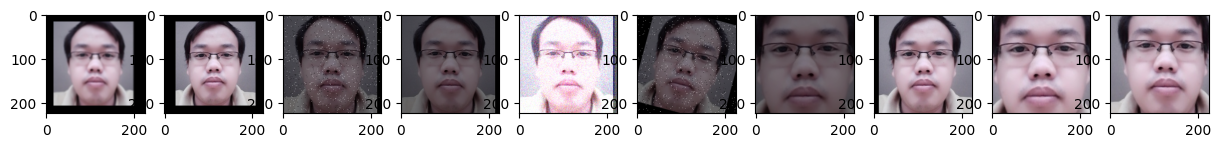

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt
import math

n = 10

# Randomly selecting a random image from train set
img = X_train[np.random.randint(0, len(X_train))]

ax = tuple([] for _ in range(n))
fig, ax = plt.subplots(1, n, figsize=(15, 15))
for i in range(n):
    x = rand_transform(img)
    ax[i].imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

In [ ]:
# Looking more into the data

def race_age_da(X_train, Y_train, M_train):
  def gen_n(X, Y, M, n):
    X += [rand_transform(X_train[i]) for _ in range(n)]
    Y += [Y_train[i] for _ in range(n)]
    M += [M_train[i] for _ in range(n)]
    return X, Y, M

  X_new, Y_new, M_new = [], [], []
  for i in range(len(X_train)):
    # age
    if Y_train[i] < 0.05: n = 2
    elif Y_train[i] < 0.1: n = 4
    elif Y_train[i] < 0.15: n = 5
    elif Y_train[i] < 0.2: n = 1
    elif Y_train[i] < 0.3: n = 1
    elif Y_train[i] < 0.4: n = 1
    elif Y_train[i] < 0.5: n = 2
    elif Y_train[i] < 0.6: n = 3
    elif Y_train[i] < 0.7: n = 5
    elif Y_train[i] < 1.: n = 20
    else: n = 1

    # race
    if M_train[i,1] == 'caucasian': n = math.ceil(n / 5)
    elif M_train[i,1] == 'asian': n *= 3
    elif M_train[i,1] == 'afroamerican': n *= 6

    # happiness
    if M_train[i,2] == 'Other': n *= 6
    elif M_train[i,1] == 'Happy': n *= 3

    X_new, Y_new, M_new = gen_n(X_new, Y_new, M_new, n)


  X_new, Y_new, M_new = np.array(X_new), np.array(Y_new), np.array(M_new)
  return X_new, Y_new, M_new

In [ ]:
X_train, Y_train, M_train = race_age_da(X_train, Y_train, M_train)

In [ ]:
print(X_train.shape[0])

4682


(0.0, 100.0)

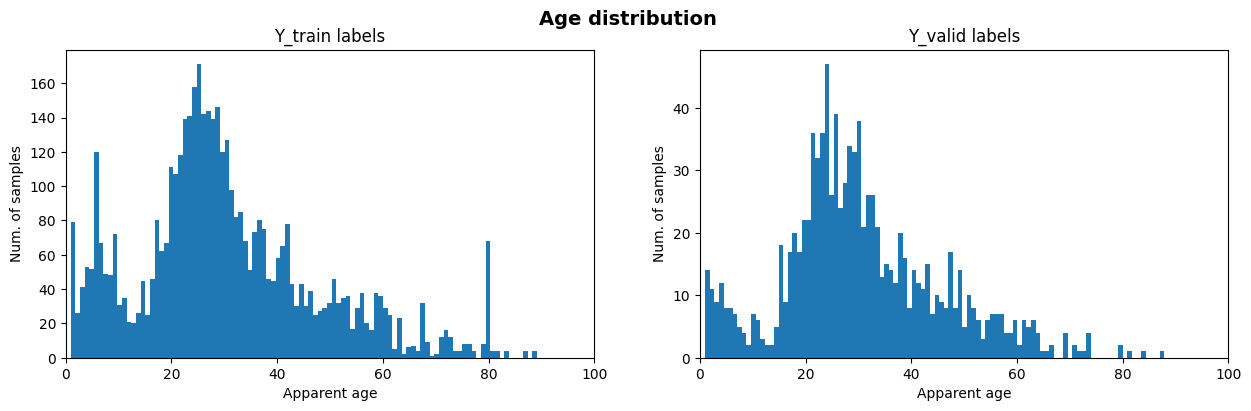

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 100)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 100)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])

In [ ]:
def show_bias(M):
    gender = []
    etnhicity = []
    emotion = []
    for sample in M:
      gender.append(sample[0])
      etnhicity.append(sample[1])
      emotion.append(sample[2])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

    ax1.hist(gender)
    ax2.hist(etnhicity)
    ax3.hist(emotion)

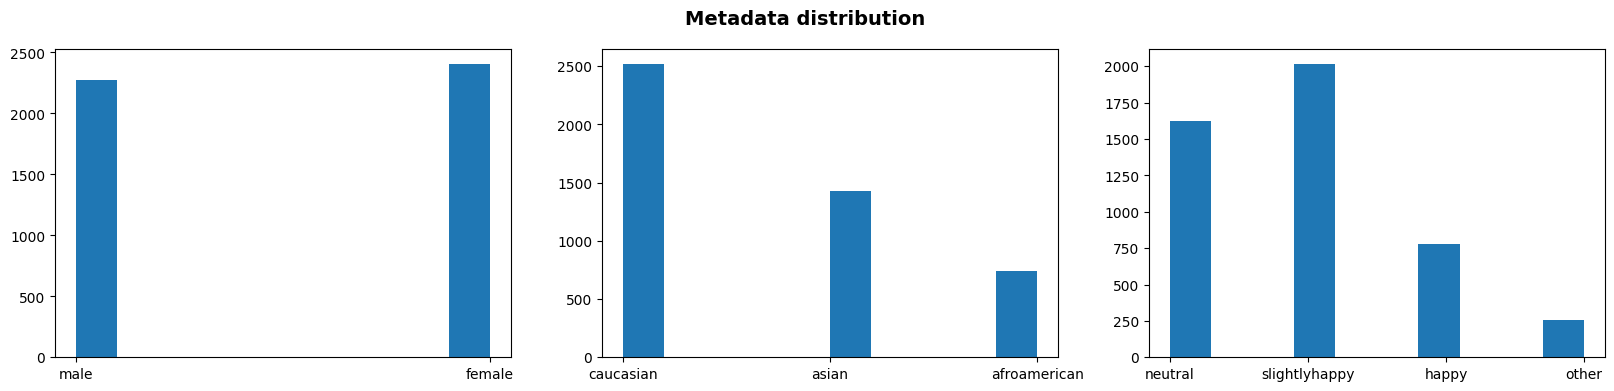

In [ ]:
show_bias(M_train)

## Custom loss 1a

In [13]:
weights = {}
total = len(Y_train)
def get_weight(n, x):
  return (5 + total)/(5 + n * x)

In [14]:
n = 2

male = (M_train[:,0] == 'male').sum()
female = (M_train[:,0] == 'female').sum()

weights['male'] = get_weight(n, male)
weights['female'] = get_weight(n, female)

print(f"\tSupport\tWeight")
print(f"male\t{male}\t{get_weight(n, male)}")
print(f"female\t{female}\t{get_weight(n, female)}")

	Support	Weight
male	1432	0.9933774834437086
female	1413	1.0067114093959733


In [15]:
n = 3

cauc = (M_train[:,1] == 'caucasian').sum()
afro = (M_train[:,1] == 'afroamerican').sum()
asia = (M_train[:,1] == 'asian').sum()

weights['caucasian'] = get_weight(n, cauc)
weights['afroamerican'] = get_weight(n, afro)
weights['asian'] = get_weight(n, asia)

print(f"\t\tSupport\tWeight")
print(f"caucasian\t{cauc}\t{get_weight(n, cauc)}")
print(f"afroamerican\t{afro}\t{get_weight(n, afro)}")
print(f"asian\t\t{asia}\t{get_weight(n, asia)}")

		Support	Weight
caucasian	2441	0.38891921397379914
afroamerican	90	10.363636363636363
asian		314	3.009503695881732


In [16]:
n = 4

happ = (M_train[:,2] == 'happy').sum()
othe = (M_train[:,2] == 'other').sum()
neut = (M_train[:,2] == 'neutral').sum()
slig = (M_train[:,2] == 'slightlyhappy').sum()

weights['happy'] = get_weight(n, happ)
weights['other'] = get_weight(n, othe)
weights['neutral'] = get_weight(n, neut)
weights['slightlyhappy'] = get_weight(n, slig)


print(f"\t\tSupport\tWeight")
print(f"happy\t\t{happ}\t{get_weight(n, happ)}")
print(f"other\t\t{othe}\t{get_weight(n, othe)}")
print(f"neutral\t\t{neut}\t{get_weight(n, neut)}")
print(f"slightlyhappy\t{slig}\t{get_weight(n, slig)}")

		Support	Weight
happy		491	1.4474352463179279
other		122	5.780933062880324
neutral		968	0.7351044622130514
slightlyhappy	1264	0.5631298162418494


In [17]:
n = 85

Y_round = np.round(Y_train*100)

print(f"\t\tSupport\tWeight")
for i in range(0, 101):
  age = (Y_round==i).sum()
  weights[i] = get_weight(n, age)
  print(f"{i}\t{age}\t{get_weight(n, age)}")

		Support	Weight
0	0	570.0
1	36	0.9298531810766721
2	31	1.0795454545454546
3	14	2.3849372384937237
4	38	0.8809891808346213
5	36	0.9298531810766721
6	33	1.0142348754448398
7	23	1.4540816326530612
8	19	1.7592592592592593
9	15	2.2265625
10	10	3.3333333333333335
11	7	4.75
12	8	4.160583941605839
13	9	3.7012987012987013
14	14	2.3849372384937237
15	18	1.8566775244299674
16	35	0.9563758389261745
17	48	0.6976744186046512
18	45	0.7441253263707572
19	59	0.5677290836653387
20	91	0.3682170542635659
21	77	0.4351145038167939
22	95	0.3527227722772277
23	113	0.29656607700312176
24	128	0.26182820395039047
25	112	0.2992125984251969
26	114	0.29396596183599794
27	109	0.3074433656957929
28	107	0.3131868131868132
29	106	0.3161397670549085
30	84	0.3988803358992302
31	78	0.4295403165033911
32	77	0.4351145038167939
33	69	0.4855195911413969
34	62	0.5402843601895735
35	52	0.6440677966101694
36	66	0.5075690115761353
37	67	0.5
38	48	0.6976744186046512
39	45	0.7441253263707572
40	41	0.8166189111747851
41	41	0.816618

In [ ]:
# Example

idx = 123
print(Y_train[idx]*100)
print(M_train[idx])
weight = weights[Y_round[idx]] * weights[M_train[idx][0]] * weights[M_train[idx][1]] * weights[M_train[idx][2]]
weight

46.6153846153846
['male' 'caucasian' 'slightlyhappy']


0.3306936241956406

In [ ]:
sample_weights = np.array([weights[Y_round[idx]] * weights[M_train[idx][0]] * weights[M_train[idx][1]] * weights[M_train[idx][2]]
                          for idx in range(len(Y_train))])

In [ ]:
print(sample_weights)

[0.2839204  0.1199841  0.11707643 ... 0.80321872 0.13797415 1.54730154]


In [ ]:
males = 0
females = 0
for i in range(len(M_train)):
  if M_train[i][0] == 'male':
    males += sample_weights[i]
  elif M_train[i][0] == 'female':
    females += sample_weights[i]

print(males)
print(females)

2491.186338295096
1950.4217151805076


In [ ]:
# as we can see, while at the beginning this custom loss leveled the weights for all,
# when we add it all together, it worsens other metrics.
# We will now create one that does not do this

## Custom loss 1b

Variation with the age loss considered by groups

In [18]:
n = 4

young = (Y_train <= 0.20).sum()
adult = ((Y_train > 0.20) & (Y_train <= 0.40)).sum()
senior = ((Y_train > 0.40) & (Y_train <= 0.60)).sum()
old = (Y_train > 0.60).sum()

weights['young'] = get_weight(n, young)
weights['adult'] = get_weight(n, adult)
weights['senior'] = get_weight(n, senior)
weights['old'] = get_weight(n, old)


print(f"\tSupport\tWeight")
print(f"young\t{young}\t{get_weight(n, young)}")
print(f"adult\t{adult}\t{get_weight(n, adult)}")
print(f"senior\t{senior}\t{get_weight(n, senior)}")
print(f"old\t{old}\t{get_weight(n, old)}")

	Support	Weight
young	539	1.3188338732068488
adult	1680	0.42379182156133827
senior	523	1.3590844062947067
old	103	6.83453237410072


In [ ]:
def get_age(i):
  if Y_train[i] <= 0.20: return "young"
  elif (Y_train[i] > 0.20) and (Y_train[i] <= 0.40): return "adult"
  elif (Y_train[i] > 0.40) and (Y_train[i] <= 0.60): return "senior"
  elif Y_train[i] > 0.60: return "old"



# Example

idx = 123
print(Y_train[idx]*100)
print(M_train[idx])
weight = weights[get_age(idx)] * weights[M_train[idx][0]] * weights[M_train[idx][1]] * weights[M_train[idx][2]]
weight

58.461538461538495
['male' 'asian' 'neutral']


1.1489838143839433

In [ ]:
weights = {
    'male': 0.35,
    'female': 0.5,
    'caucasian': 0.4,
    'afroamerican': 15.,
    'asian': 4.,
    'happy': 2.,
    'other': 7.,
    'neutral': 1.,
    'slightlyhappy': 1.,
    'young': 0.8,
    'adult': 0.3,
    'senior': 1.5,
    'old': 10.,
}

In [ ]:
sample_weights = np.array([weights[get_age(idx)] * weights[M_train[idx][0]] * weights[M_train[idx][1]] * weights[M_train[idx][2]]
                          for idx in range(len(Y_train))])

In [ ]:
print(sample_weights)

[0.22274613 0.17023342 0.17023342 ... 1.3193432  0.17023342 1.35535188]


## Custom loss 2a

In [ ]:
n = 2 * 3 * 4 * 100
n

2400

In [ ]:
# create weigth dict

wd = {}
for gender in ['male', 'female']:
  wd[gender] = {}
  for ethnicity in ['caucasian', 'afroamerican', 'asian']:
    wd[gender][ethnicity] = {}
    for expression in ['happy', 'other', 'neutral', 'slightlyhappy']:
      wd[gender][ethnicity][expression] = {}
      for age in range(0, 101):
        mask = (M_train[:,0]==gender) & (M_train[:,1]==ethnicity) & (M_train[:,2]==expression) & (Y_round == age)
        support = mask.sum()
        if support > 0:
          wd[gender][ethnicity][expression][age] = (5 + total)/(5 + n * support)
          #print(f"{gender}, {ethnicity}, {expression}, {age}: {wd[gender][ethnicity][expression][age]}")
        else:
          wd[gender][ethnicity][expression][age] = 0



In [ ]:
sumas = {'caucasian':0, 'afroamerican':0, 'asian':0, 'male':0, 'female':0,
         'happy':0, 'other':0, 'neutral':0, 'slightlyhappy':0}

for gender in ['male', 'female']:
  for ethnicity in ['caucasian', 'afroamerican', 'asian']:
    for expression in ['happy', 'other', 'neutral', 'slightlyhappy']:
      for age in range(0, 101):
        s = wd[gender][ethnicity][expression][age]
        sumas[ethnicity] += s
        sumas[gender] += s
        sumas[expression] += s
print(sumas)

{'caucasian': 361.2529174856477, 'afroamerican': 19.01878142279976, 'asian': 55.45885024360472, 'male': 213.94868195481442, 'female': 221.78186719723632, 'happy': 120.43875085722355, 'other': 105.15473097508718, 'neutral': 110.33466247905581, 'slightlyhappy': 99.80240484068575}


In [ ]:
# However this loss is even more unbalanced as most datasets contain only 1 image

In [ ]:
sample_weights = np.array([wd[M_train[idx][0]][M_train[idx][1]][M_train[idx][2]][Y_round[idx]]
                          for idx in range(len(Y_train))])

In [ ]:
sample_weights

array([0.13017636, 0.07232467, 0.07232467, ..., 1.94885655, 0.08876053,
       0.97544225])

## Custom loss 2b

In [ ]:
n = 2 * 3 * 4 * 4
n

96

In [ ]:
# create weigth dict

age_mask = {"young": Y_train <= 0.20,
            "adult": (Y_train > 0.20) & (Y_train <= 0.40),
            "senior": (Y_train > 0.40) & (Y_train <= 0.60),
            "old": Y_train > 0.60}

wd = {}
for gender in ['male', 'female']:
  wd[gender] = {}
  for ethnicity in ['caucasian', 'afroamerican', 'asian']:
    wd[gender][ethnicity] = {}
    for expression in ['happy', 'other', 'neutral', 'slightlyhappy']:
      wd[gender][ethnicity][expression] = {}
      for age in ["young", "adult", "senior", "old"]:
        mask = (M_train[:,0]==gender) & (M_train[:,1]==ethnicity) & (M_train[:,2]==expression)
        mask = mask & age_mask[age]
        support = mask.sum()
        if support > 0:
          wd[gender][ethnicity][expression][age] = (total)/(n * support)
        else:
          wd[gender][ethnicity][expression][age] = 0
        #print(f"{gender}, {ethnicity}, {expression}, {age}: {wd[gender][ethnicity][expression][age]}")



In [ ]:
sumas = {'caucasian':0, 'afroamerican':0, 'asian':0, 'male':0, 'female':0,
         'happy':0, 'other':0, 'neutral':0, 'slightlyhappy':0,
         "young":0, "adult":0, "senior":0, "old":0}

for gender in ['male', 'female']:
  for ethnicity in ['caucasian', 'afroamerican', 'asian']:
    for expression in ['happy', 'other', 'neutral', 'slightlyhappy']:
      for age in ["young", "adult", "senior", "old"]:
        s = wd[gender][ethnicity][expression][age]
        sumas[ethnicity] += s
        sumas[gender] += s
        sumas[expression] += s
        sumas[age] += s
print(sumas)

{'caucasian': 116.92161823771961, 'afroamerican': 39.47097779727987, 'asian': 44.415043080823224, 'male': 117.33212636320036, 'female': 83.47551275262235, 'happy': 41.17290617107237, 'other': 118.41295594837263, 'neutral': 21.464736259914808, 'slightlyhappy': 19.7570407364629, 'young': 35.697359708111044, 'adult': 34.7988161797621, 'senior': 44.31699316495495, 'old': 85.99447006299461}


## Custom loss 3

In [19]:
weights = {
    'male': 0.35,
    'female': 0.5,
    'caucasian': 0.4,
    'afroamerican': 15.,
    'asian': 4.,
    'happy': 2.,
    'other': 7.,
    'neutral': 1.,
    'slightlyhappy': 1.,
    'young': 0.8,
    'adult': 0.3,
    'senior': 1.5,
    'old': 10.,
}

In [20]:
def get_age(i):
  if Y_train[i] <= 0.20: return "young"
  elif (Y_train[i] > 0.20) and (Y_train[i] <= 0.40): return "adult"
  elif (Y_train[i] > 0.40) and (Y_train[i] <= 0.60): return "senior"
  elif Y_train[i] > 0.60: return "old"

In [21]:
sample_weights = np.array([weights[get_age(idx)] * weights[M_train[idx][0]] * weights[M_train[idx][1]] * weights[M_train[idx][2]]
                          for idx in range(len(Y_train))])

In [22]:
print(f"male total: \t\t{sample_weights[M_train[:,0]=='male'].sum()}")
print(f"female total: \t\t{sample_weights[M_train[:,0]=='female'].sum()}")
print(f"caucasian total: \t{sample_weights[M_train[:,1]=='caucasian'].sum()}")
print(f"afroamerican total: \t{sample_weights[M_train[:,1]=='afroamerican'].sum()}")
print(f"asian total: \t\t{sample_weights[M_train[:,1]=='asian'].sum()}")
print(f"happy total: \t\t{sample_weights[M_train[:,2]=='happy'].sum()}")
print(f"other total: \t\t{sample_weights[M_train[:,2]=='other'].sum()}")
print(f"neutral total: \t\t{sample_weights[M_train[:,2]=='neutral'].sum()}")
print(f"slightlyhappy total: \t{sample_weights[M_train[:,2]=='slightlyhappy'].sum()}")
ages = np.array([get_age(i) for i in range(len(Y_train))])
print(f"young total: \t\t{sample_weights[ages=='young'].sum()}")
print(f"adult total: \t\t{sample_weights[ages=='adult'].sum()}")
print(f"senior total: \t\t{sample_weights[ages=='senior'].sum()}")
print(f"old total: \t\t{sample_weights[ages=='old'].sum()}")

male total: 		807.975
female total: 		858.5400000000001
caucasian total: 	574.47
afroamerican total: 	527.025
asian total: 		565.02
happy total: 		386.43000000000006
other total: 		452.20000000000005
neutral total: 		387.245
slightlyhappy total: 	440.64
young total: 		421.15200000000004
adult total: 		436.578
senior total: 		411.585
old total: 		397.19999999999993


## Train

In [ ]:
# train set
X_train = X_train.astype('float32')
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

# validation set
X_valid = X_valid.astype('float32')
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = tf.keras.applications.resnet50.preprocess_input(x)

### 1st stage

In [ ]:
download_model = True

if download_model:
  # downloading the ResNet50
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/model.zip

  # decompressing the data
  from zipfile import ZipFile

  with ZipFile('model.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')

  # removing the .zip file after extraction  to clean space
  !rm model.zip

--2024-03-28 00:30:31--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/model.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893665 (103M) [application/zip]
Saving to: ‘model.zip’

model.zip           100%[===================>] 102.89M  3.19MB/s    in 43s     

2024-03-28 00:31:16 (2.37 MB/s) - ‘model.zip’ saved [107893665/107893665]

Model decompressed successfully


In [ ]:
import h5py

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

In [ ]:
# Building the last layers
fc_512 = model.get_layer('dim_proj').output
dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)
fc_128 = tf.keras.layers.Dense(128, activation='relu', name='f_128')(dp_layer)
fc_32 = tf.keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

model = tf.keras.models.Model(inputs=model.get_layer('base_input').output,outputs=output)

In [ ]:
counter = 0
for layer in model.layers:
  if counter <= 174:
    layer.trainable = False
  else:
    layer.trainable = True
  counter +=1

In [ ]:
import pickle

# load a model and train history
#--------------------------
LOAD_BEST_MODEL_ST1 = False # (training only the last FC layers)
#--------------------------

if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
else:
  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  # saving the best model based on val_loss
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model.fit(X_train, Y_train,  sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
146/147 [============================>.] - ETA: 0s - loss: 0.3362 - mae: 0.3009

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 22s 120ms/step - loss: 0.3364 - mae: 0.3012 - val_loss: 0.2884 - val_mae: 0.2896
Epoch 2/50
147/147 [==============================] - 20s 136ms/step - loss: 0.3117 - mae: 0.2884 - val_loss: 0.2870 - val_mae: 0.2850
Epoch 3/50
147/147 [==============================] - 17s 115ms/step - loss: 0.2957 - mae: 0.2842 - val_loss: 0.2777 - val_mae: 0.2811
Epoch 4/50
147/147 [==============================] - 19s 131ms/step - loss: 0.2930 - mae: 0.2764 - val_loss: 0.2742 - val_mae: 0.2812
Epoch 5/50
147/147 [==============================] - 17s 119ms/step - loss: 0.2886 - mae: 0.2778 - val_loss: 0.2785 - val_mae: 0.2837
Epoch 6/50
147/147 [==============================] - 20s 133ms/step - loss: 0.2842 - mae: 0.2729 - val_loss: 0.2741 - val_mae: 0.2792
Epoch 7/50
147/147 [==============================] - 15s 102ms/step - loss: 0.2815 - mae: 0.2706 - val_loss: 0.2765 - val_mae: 0.2812
Epoch 8/50
147/147 [==============================] - 19s 132ms/st

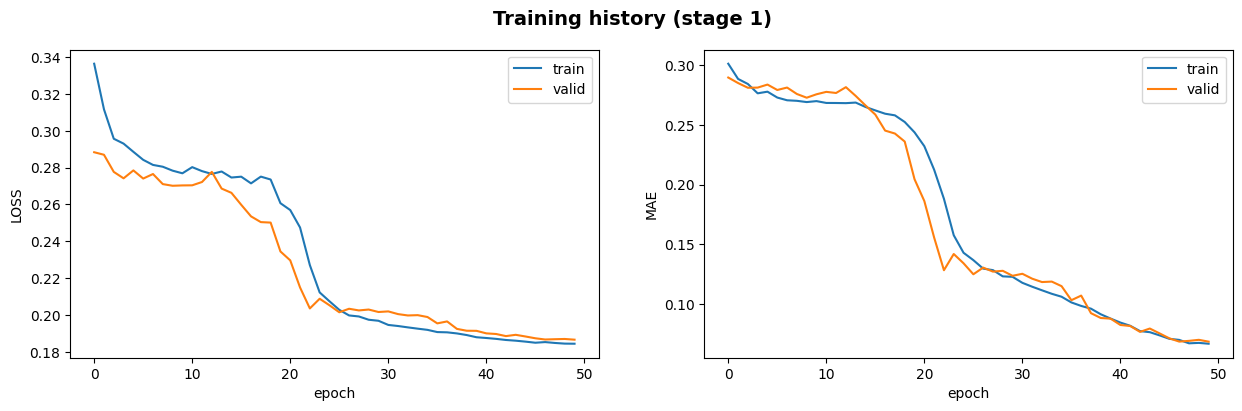

In [ ]:
from matplotlib import pyplot as plt

# here, it loads the history of the model we have already trained, or loads the
# history of the model you defined and trained
if(LOAD_BEST_MODEL_ST1==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')


### 2nd stage

In [ ]:
del model

In [ ]:
import pickle

#--------------------------
LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False
NUM_EPOCHS = 30
#--------------------------
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 9
#--------------------------

if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024/best_model_st2_weighted.zip
  # decompressing the data
  with ZipFile('best_model_st2_weighted.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2_weighted.zip

else:
  # loading the saved model (best model learned at stage 1)
  if(RESUME_TRAINING == False):
    model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model.h5') # load model from stage 1
  else:
    # resume training (stage 2)
    model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

  # setting all layers to traineble
  model.trainable = True

  #=================================================
  # training all layers (2nd stage), given the model saved on stage 1
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
  #=================================================

  # defining the early stop criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_loss.h5', monitor='val_loss', mode='min', save_best_only=True)

  if(RESUME_TRAINING == False):
    history = model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
    # saving training history
    with open('/content/gdrive/MyDrive/temp/train_history_loss.pkl', 'wb') as handle:
      pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  else:
    history = model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es,mc])
    # in this code, the training history is not saved if you resume training


Epoch 1/30
293/293 [==============================] - 95s 240ms/step - loss: 0.1848 - mae: 0.0732 - val_loss: 0.1816 - val_mae: 0.0540
Epoch 2/30
293/293 [==============================] - 62s 213ms/step - loss: 0.1802 - mae: 0.0603 - val_loss: 0.1797 - val_mae: 0.0571
Epoch 3/30
293/293 [==============================] - 63s 214ms/step - loss: 0.1772 - mae: 0.0581 - val_loss: 0.1764 - val_mae: 0.0517
Epoch 4/30
293/293 [==============================] - 64s 217ms/step - loss: 0.1741 - mae: 0.0545 - val_loss: 0.1736 - val_mae: 0.0513
Epoch 5/30
293/293 [==============================] - 65s 221ms/step - loss: 0.1710 - mae: 0.0522 - val_loss: 0.1719 - val_mae: 0.0575
Epoch 6/30
293/293 [==============================] - 68s 231ms/step - loss: 0.1687 - mae: 0.0522 - val_loss: 0.1686 - val_mae: 0.0521
Epoch 7/30
293/293 [==============================] - 60s 206ms/step - loss: 0.1657 - mae: 0.0486 - val_loss: 0.1653 - val_mae: 0.0464
Epoch 8/30
293/293 [==============================] - 6

In [ ]:
from matplotlib import pyplot as plt
import pickle

if(RESUME_TRAINING == False):
  if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
    train_hist_2nd = pickle.load(open("train_history_2nd_stage_weighted.pkl","rb"))
  else:
    train_hist_2nd = pickle.load(open("/content/gdrive/MyDrive/temp/train_history_loss.pkl","rb"))
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
  fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

  ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
  ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
  ax1.set(xlabel='epoch', ylabel='Loss')
  ax1.legend(['train', 'valid'], loc='upper right')

  ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
  ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
  ax2.set(xlabel='epoch', ylabel='MAE')
  ax2.legend(['train', 'valid'], loc='upper right')

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/temp/train_history_loss.pkl'

In [ ]:
del X_train, Y_train, M_train

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/MyDrive/temp/best_model_loss.h5')

In [ ]:
predictions_st2_weighted = model.predict(X_valid, batch_size=32, verbose=1)*100

33/33 [==============================] - 198s 6s/step


In [ ]:
# evaluating on validation data
error = []
for i in range(0,len(Y_valid)):
  error.append(abs(np.subtract(predictions_st2_weighted[i][0],Y_valid[i]*100)))

print('MAE (validation set - with custom loss) = %.8f' %(np.mean(error)))

MAE (validation set - with custom loss) = 4.09265385


In [ ]:
# downloading our "bias library", which contains the functions used to evaluate
# the different bias scores
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py

--2024-03-28 09:23:54--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/bias_functions.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4355 (4.3K) [application/octet-stream]
Saving to: ‘bias_functions.py’

bias_functions.py   100%[===================>]   4.25K  --.-KB/s    in 0s      

2024-03-28 09:23:55 (483 MB/s) - ‘bias_functions.py’ saved [4355/4355]



In [ ]:
# importing the functions used to evaluate the different biases
from bias_functions import age_bias, gender_bias, ethnicity_bias, face_expression_bias

age_bias(predictions_st2_weighted,Y_valid*100)

gender_bias(predictions_st2_weighted,Y_valid*100,M_valid)

ethnicity_bias(predictions_st2_weighted,Y_valid*100,M_valid)

face_expression_bias(predictions_st2_weighted,Y_valid*100,M_valid)

Age analysis:
Size group 1 = 205, MAE = 2.706953
Size group 2 = 590, MAE = 3.936689
Size group 3 = 197, MAE = 5.150044
Size group 4 = 45, MAE = 7.821149
---------
Age bias (Ba) =  2.759324073791504
Gender analysis:
Size group female = 497, MAE = 4.443587
Size group male = 540, MAE = 3.769666
---------
Gender bias (Bg) =  0.6739216
Ethnicity Analysis:
Size group asian = 79, MAE = 4.391836
Size group afroamerican = 32, MAE = 3.197541
Size group caucasian = 926, MAE = 4.098062
---------
Ethnicity bias (Be) =  0.7961966196695963
Face experession Analysis:
Size group happy = 298, MAE = 4.329298
Size group slightlyhappy = 311, MAE = 4.320140
Size group neutral = 351, MAE = 3.817961
Size group other = 77, MAE = 3.510177
---------
Face Expression bias (Bf) =  0.4932568470637004


## Test

In [ ]:
del X_valid, Y_valid, M_valid

In [ ]:
# loading the test data (with labels)
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')

#=================================================================
# post-processing the test data with respect to ResNet-50 Inputs.
#=================================================================
# test set
X_test = X_test.astype('float32')
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = tf.keras.applications.resnet50.preprocess_input(x)

print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)

----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)


In [ ]:
# making predictions on the TEST data (and re-scalling the predictions to the range of "ages")
predictions_st2_test = model.predict(X_test, batch_size=32, verbose=1)*100

62/62 [==============================] - 339s 5s/step


In [ ]:
# evaluating on test data
# note, the Y_test labels were not normalized, so they don't need to be re-scaled back
error = []
for i in range(0,len(Y_test)):
  error.append(abs(np.subtract(predictions_st2_test[i][0],Y_test[i])))

print('MAE (model stage 2 (custom loss), TEST set) = %.8f' %(np.mean(error)))

# printing some predictions
print('-----')
for i in range(0,10):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_test[i], Y_test[i]))

MAE (model stage 2 (custom loss), TEST set) = 7.45511024
-----
predicted age = 22.625 - Ground truth = 23.205
predicted age = 44.552 - Ground truth = 70.737
predicted age = 28.917 - Ground truth = 55.368
predicted age = 23.757 - Ground truth = 24.278
predicted age = 22.737 - Ground truth = 25.231
predicted age = 31.471 - Ground truth = 35.179
predicted age = 38.345 - Ground truth = 26.923
predicted age = 35.276 - Ground truth = 48.189
predicted age = 17.322 - Ground truth = 18.676
predicted age = 45.598 - Ground truth = 57.378


<ipython-input-17-1c8e1b84a8ca>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st2_test[i], Y_test[i]))


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_test)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions_weighted_2.zip predictions.csv

  adding: predictions.csv (deflated 55%)


In [ ]:
!cp predictions_da_loss_2.zip /content/gdrive/Shareddrives/Computer_Vision/Task2

cp: cannot stat 'predictions_da_loss_2.zip': No such file or directory
